<a href="https://colab.research.google.com/github/hiyama341/ConStrain/blob/main/colab_notebooks/01_DESIGN_PromoterSelection_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 01-DESIGN_PromoterSelection

In [ ]:
from csv import reader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
!git clone https://github.com/hiyama341/ConStrain_on_google_colab.git

fatal: destination path 'ConStrain_on_google_colab' already exists and is not an empty directory.


### 1. Intro

Promoters are a major component of protein expression and are a key driver of biological systems (Kotopka & Smolke, 2020). To make a library with diversity and unique expression levels and kinetics I want to look for characteristics such as:  

- High/low constitutive expression
- Increase/decrease in expression over time.

**We want to automate and standardize the selection process with an algorithm**

**About the Data used here**:
Selection can be automated from RNA-seq data, where mRNAs are sequenced, mapped to specific genes, and added to a count matrix. It is important to note that this method could be modified and applied to other data sets or organisms.
In S. cerevisiae, promoters are defined as the 1kb upstream of the transcriptional start site (TSS)(a lab standard) and therefore make them easy to retrieve. The RNA-seq data used here was generated by Arun et al (Rajkumar et al., 2019) and the data is composed of three columns representing time points i.e samples taken at 6 hours, 12, hours and 24 hours. The 6303 rows represent the genes of S. cerevisiae and each has RNA counts for each of the time points. 

**The method for finding the set of promoters we're interesed is described as follows:**

1. Load in RNA-seq data
2. Pre-process the data i.e sort, remove irrelevant data points(zero counts), and set a lower limit for what is considered low-expression, etc. 
3. Consider what expression dynamics are interesting and search through the pre-processed data
4. Save best candidates in each group of expression dynamics.
5. Retrieve the sequences of these (Upstream sequences of TSS) from the sequence database. 
6. Align the sequences to avoid homology. 
7. Chosen promoters should be saved and bounced to an external database. 


### 2. Data-processing

First step in this workflow is to read the RNAseq data in. 

In [ ]:
df = pd.read_csv('/content/ConStrain_on_google_colab/Data/RNA_seq_data/RNAseq_reads_arun.csv', index_col=0)

In [ ]:
df

,NIL_6h_FPKM,NIL_12h_FPKM,NIL_24h_FPKM
gene_short_name,,,
YAL067W-A,3.455130,2.519210,5.707320
YAL064W-B,0.000000,0.000000,0.000000
YAL064W,4.640590,2.375570,8.673990
GDH3,22.330000,10.552100,41.387300
BDH2,72.564100,48.697600,120.082000
...,...,...,...
tV(UAC)Q,0.000000,0.000000,0.000000
COX3,0.122102,0.153141,0.155030
tM(CAU)Q2,0.000000,0.000000,0.000000


Then we can sort all values

In [ ]:
df.sort_values(by=['NIL_6h_FPKM'], ascending = False)

,NIL_6h_FPKM,NIL_12h_FPKM,NIL_24h_FPKM
gene_short_name,,,
RPL41B,14291.10,17886.20,10638.800
SPO24,8863.45,4976.59,15027.100
YDR524W-A,5996.15,8357.58,3777.040
RPL41A,5696.18,8116.95,2164.460
TDH3,5623.80,5198.45,845.219
...,...,...,...
tD(GUC)J3,0.00,0.00,0.000
tR(UCU)J2,0.00,0.00,0.000
EMT5,0.00,0.00,0.000


It turns out we have a many of genes that do not have any counts in the dataset. We are not interested in these genes since they are most likely controlled by inducible promoters so we filter them out. 

#### Getting rid of zeros

In [ ]:
df = df.loc[~(df==0).all(axis=1)]
df

,NIL_6h_FPKM,NIL_12h_FPKM,NIL_24h_FPKM
gene_short_name,,,
YAL067W-A,3.455130,2.519210,5.707320
YAL064W,4.640590,2.375570,8.673990
GDH3,22.330000,10.552100,41.387300
BDH2,72.564100,48.697600,120.082000
BDH1,169.859000,43.289800,282.497000
...,...,...,...
21S_RRNA,0.240608,0.261625,0.234314
SCEI,0.091711,0.000000,0.000000
COX2,0.031348,0.000000,0.000000


After filtering all the genes out that were only zero, I notice that there are still some genes with close to zero counts but we will deal with that later. Lets plot the data. 

### Plotting the data with counts (y-axis) and genes (x-axis)

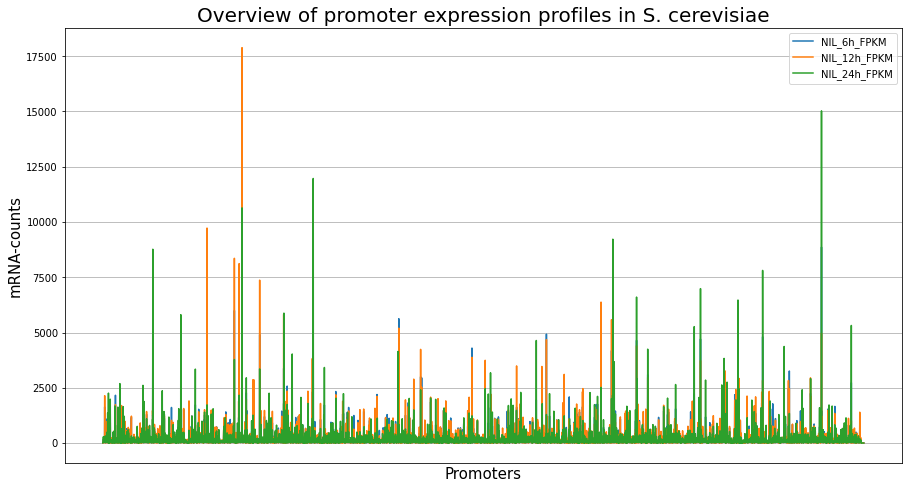

In [ ]:
df.plot(legend = True, figsize=(15, 8))
plt.xticks(rotation=30, horizontalalignment="center")
plt.title("Overview of promoter expression profiles in S. cerevisiae", fontsize = 20)
plt.xlabel("Promoters",fontsize = 15)
plt.ylabel("mRNA-counts", fontsize = 15)

ax = plt.gca()
ax.axes.xaxis.set_ticks([])

plt.grid(True)

#plt.savefig('../pictures/Overview_of_promoter_expression profiles.png', dpi = 200)

The plotted data shows us that there are approximately 20 genes that at some point in during the have RNA counts of >5000. Most other genes are found to have < 1000 counts.  

Additionally, as we saw before quite a lot of data points have RNA counts close to zero and as we are not interested in promoters that do not express anyhting. They can be filtered out. 

I choose to put a threshold expression level - arbitrarily chosen and can differ from dataset to dataset. Genes with counts less than 2000 counts combined from all timepoints were filtered out.  


In [ ]:
threshold = 500
df_with_threshold = df[df['NIL_6h_FPKM']+ df['NIL_12h_FPKM']+ df['NIL_24h_FPKM'] > threshold]
df_with_threshold

,NIL_6h_FPKM,NIL_12h_FPKM,NIL_24h_FPKM
gene_short_name,,,
YAL044W-A,245.231,267.378,274.042
ERV46,175.469,163.851,194.748
CDC19,1632.650,2142.150,101.161
SNC1,279.743,290.354,321.153
TPD3,169.746,193.391,178.816
...,...,...,...
YPR148C,291.884,334.582,314.950
SUE1,175.959,238.277,177.910
TIF3,271.151,348.866,155.819


In [ ]:
ind_list = ['CYC1', 'ENO2', 'PCK1', 'RPL15B', 'CCW12', 'MLS1', 'TPI1', 'URE2']
result = df_with_threshold.loc[ind_list]
result


,NIL_6h_FPKM,NIL_12h_FPKM,NIL_24h_FPKM
gene_short_name,,,
CYC1,2775.830,3742.74000,2459.6600
ENO2,2950.220,2527.27000,84.3614
PCK1,1948.900,9.80902,4639.4100
RPL15B,200.212,186.50900,258.0280
CCW12,5496.460,6376.54000,2516.0500
MLS1,2222.160,8.09464,5267.0000
TPI1,2264.780,2853.86000,209.1640
URE2,253.590,344.07600,222.4390


This step filtered out most of the genes with 303 remaining promoters. With this amount of promoters let's look at the dynamics in a line-diagram to get an understanding how they increase or decrease over time

#### Plotting the dynamics from the remeaing promoters

Pandas uses by definition the index as x-axis for plotting. If we transpose the dataframe we can plot every promoter and see their dynamics

In [ ]:
df_transposed = df_with_threshold.transpose()
df_transposed

gene_short_name,YAL044W-A,ERV46,CDC19,SNC1,TPD3,CYS3,EFB1,ADE1,YAT1,YAR068W,...,YPR098C,RPL11A,RPC40,ANT1,SPN1,YPR148C,SUE1,TIF3,MET16,MLC2
NIL_6h_FPKM,245.231,175.469,1632.650,279.743,169.746,221.561,1088.300,884.882,989.587,167.935,...,277.070,485.3180,293.395,215.003,182.288,291.884,175.959,271.151,749.538,175.376
NIL_12h_FPKM,267.378,163.851,2142.150,290.354,193.391,273.423,970.904,542.645,115.492,119.496,...,222.019,440.4330,433.721,274.217,246.025,334.582,238.277,348.866,1395.280,248.015
NIL_24h_FPKM,274.042,194.748,101.161,321.153,178.816,109.383,487.837,1367.400,2257.820,253.858,...,403.546,81.5291,152.376,205.789,146.960,314.950,177.910,155.819,201.491,133.949


Text(0, 0.5, 'RNA-seq counts')

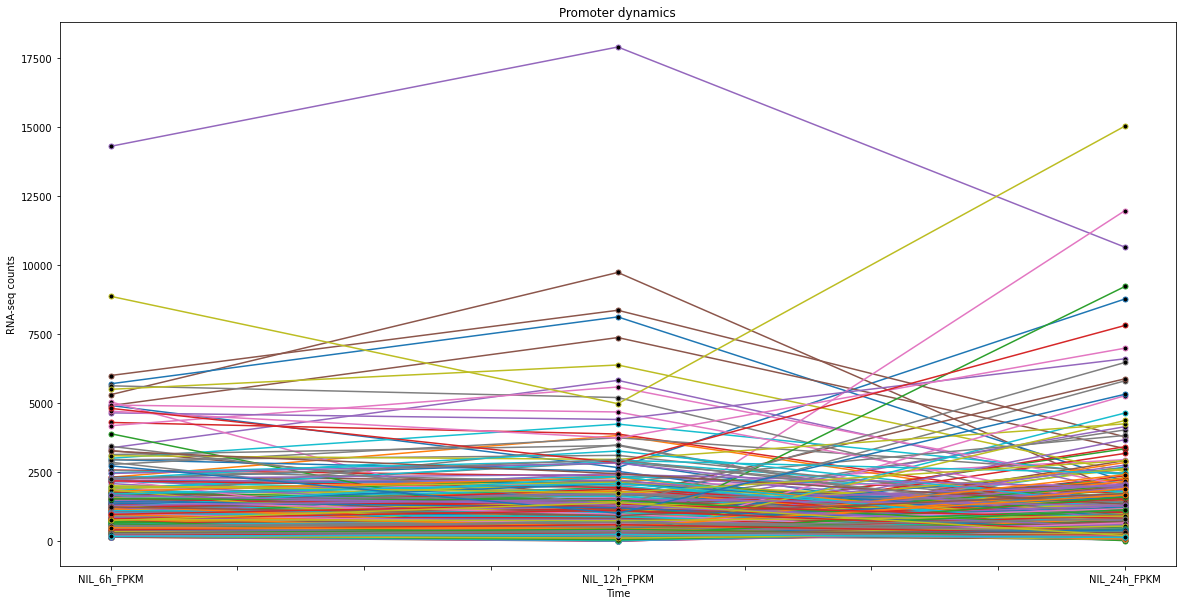

In [ ]:
transposed_plot = df_transposed.plot.line(linestyle='-', marker='o', markerfacecolor='black', legend = False, figsize=(20, 10),markersize=5, title='Promoter dynamics')
transposed_plot.set_xlabel("Time")
transposed_plot.set_ylabel("RNA-seq counts")

Sorting the values of the dataframe

In [ ]:
df_with_threshold = df_with_threshold.sort_values(by=['NIL_6h_FPKM'], ascending = False)
df_with_threshold

,NIL_6h_FPKM,NIL_12h_FPKM,NIL_24h_FPKM
gene_short_name,,,
RPL41B,14291.100,17886.2000,10638.800
SPO24,8863.450,4976.5900,15027.100
YDR524W-A,5996.150,8357.5800,3777.040
RPL41A,5696.180,8116.9500,2164.460
TDH3,5623.800,5198.4500,845.219
...,...,...,...
CBP4,155.257,68.1945,284.856
MAL11,153.011,12.1095,360.936
CLD1,152.966,92.7070,276.930


Then pick 5 genes with the highest counts and 5 genes with lowest counts and make them into a list

In [ ]:
# Selecting top5
List_of_Top5_High_constitutive_prom = df_with_threshold[:5]
List_of_Top5_Low_constitutive_prom = df_with_threshold[-5:] 

# making them into a list
List_of_Top5_High_constitutive_promoters = List_of_Top5_High_constitutive_prom.index.values.tolist() 
List_of_Top5_Low_constitutive_promoters = List_of_Top5_Low_constitutive_prom.index.values.tolist()

In [ ]:
List_of_Top5_Low_constitutive_promoters

['CBP4', 'MAL11', 'CLD1', 'AGP2', 'YAR035C-A']

### We can look for genes that have the highest/increase increase relative to the first timepoint 

#### We can investigate genes that have show the greatets difference in counts from 6 hour to 24 hour
Getting the one that has the steepest decrease in expression and steepest increase in expression with the pandas idmax function

In [ ]:
print((df_with_threshold['NIL_6h_FPKM'] - df_with_threshold['NIL_24h_FPKM']).idxmax())
print((df_with_threshold['NIL_24h_FPKM'] - df_with_threshold['NIL_6h_FPKM']).idxmax())

TDH3
ICL1


### Another way to do it is to find difference from first column to the last column: 


In [ ]:
# Lets only look at the difference between 6 and 24 hour.
df_with_DIFF_over_time_increasing = df_with_threshold[['NIL_6h_FPKM','NIL_24h_FPKM']]

In [ ]:
df_with_DIFF_over_time_increasing = df_with_DIFF_over_time_increasing.diff(axis='columns')
df_with_DIFF_over_time_increasing = df_with_DIFF_over_time_increasing.sort_values(by=['NIL_24h_FPKM' ], ascending = False)
# # df_with_change_over_time
df_with_DIFF_over_time_increasing


,NIL_6h_FPKM,NIL_24h_FPKM
gene_short_name,,
ICL1,NaN,6924.080
SPO24,NaN,6163.650
YLR307C-A,NaN,5331.290
YBR085C-A,NaN,3856.360
MLS1,NaN,3044.840
...,...,...
RPL41A,NaN,-3531.720
SED1,NaN,-3574.680
FBA1,NaN,-3636.760


This method might not work, since some of the strongest promoters with highest counts(also known from the litterature i.e TDH3, RPL41B) also fall the most in the last time point. Making them the promoters with the highest decrease over time. 

### Instead let's look at percent change over time 

In [ ]:
df_with_change_over_time = df_with_threshold.pct_change(axis='columns')
df_with_change_over_time_increasing = df_with_change_over_time.sort_values(by=['NIL_12h_FPKM', 'NIL_24h_FPKM' ], ascending = True)

# df_with_change_over_time
df_with_change_over_time_increasing

,NIL_6h_FPKM,NIL_12h_FPKM,NIL_24h_FPKM
gene_short_name,,,
YAR035C-A,NaN,-1.000000,inf
MLS1,NaN,-0.996357,649.677485
PCK1,NaN,-0.994967,471.973855
SFC1,NaN,-0.988483,210.280874
ADY2,NaN,-0.987649,199.421709
...,...,...,...
RIB4,NaN,0.906627,-0.870206
MET28,NaN,0.948386,-0.849363
PRM5,NaN,0.959731,-0.843176


KEEP in mind that it only is relative to the adjacent timepoint and not the first timepoint. The top and botton can be picked from the dataframe: 


In [ ]:
# Selecting top5
Top5_increasing_promoters = df_with_change_over_time_increasing[:5]
Top5_decreasing_promoters = df_with_change_over_time_increasing[-5:]

# Making it into a list 
List_of_Top5_increasing_promoters = Top5_increasing_promoters.index.values.tolist() 
List_of_Top5_descreasing_promoters = Top5_decreasing_promoters.index.values.tolist()
print(List_of_Top5_increasing_promoters)
print(List_of_Top5_descreasing_promoters)

['YAR035C-A', 'MLS1', 'PCK1', 'SFC1', 'ADY2']
['RIB4', 'MET28', 'PRM5', 'SRL3', 'URA1']


In [ ]:
# # Selecting the promoters by slicing
# Increasing_promoters = df_with_change_over_time_increasing[0:5]
# Decreasing_promoters = df_with_change_over_time_increasing[-5:]

# #Making them into a list
# List_of_Top5_Increasing_promoters = Increasing_promoters.index.values.tolist() 
# List_of_Top5_Decreasing_promoters = Decreasing_promoters.index.values.tolist() 

In [ ]:
Top5_increasing_promoters

,NIL_6h_FPKM,NIL_12h_FPKM,NIL_24h_FPKM
gene_short_name,,,
YAR035C-A,NaN,-1.000000,inf
MLS1,NaN,-0.996357,649.677485
PCK1,NaN,-0.994967,471.973855
SFC1,NaN,-0.988483,210.280874
ADY2,NaN,-0.987649,199.421709


In [ ]:
Top5_decreasing_promoters

,NIL_6h_FPKM,NIL_12h_FPKM,NIL_24h_FPKM
gene_short_name,,,
RIB4,NaN,0.906627,-0.870206
MET28,NaN,0.948386,-0.849363
PRM5,NaN,0.959731,-0.843176
SRL3,NaN,0.989323,-0.867229
URA1,NaN,1.154671,-0.949687


#### NOW we have 4 list consisting of: 

- List_of_Top5_High_constitutive_promoters
- List_of_Top5_Low_constitutive_promoters
- List_of_Top5_Increasing_promoters
- List_of_Top5_Decreasing_promoters


We can now look up the sequences from intermine with the following function

## 3. Fetching promoter sequences with Intermine

#### We can not fetch the 1kb upstream of these promoters with the following fucntions that can fetch sequences from the database intermine. 

In [ ]:
!pip install intermine

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from __future__ import print_function
from intermine.webservice import Service

In [ ]:
def FetchPromoter(promoter_name:str): 
    seq = ''
    service = Service("https://yeastmine.yeastgenome.org/yeastmine/service")
    query = service.new_query("Gene")
    query.add_view(
        "secondaryIdentifier", "symbol", "length", "flankingRegions.direction",
        "flankingRegions.sequence.length", "flankingRegions.sequence.residues"
    )

    query.add_constraint("Gene", "LOOKUP", promoter_name, "S. cerevisiae", code="B")
    query.add_constraint("flankingRegions.direction", "=", "upstream", code="C")
    query.add_constraint("flankingRegions.distance", "=", "1.0kb", code="A")
    query.add_constraint("flankingRegions.includeGene", "=", "false", code="D")

    for row in query.rows():
        seq = row["flankingRegions.sequence.residues"]

    return seq

In [ ]:
!pip install Bio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord

In [ ]:
%%time
def FetchMultiplePromoters(List_of_promoter_names):
    # #initializing 
    LIST_OF_BIOrecord_objects = []

    for i in range(0, len(List_of_promoter_names)):
        #fetching the seqs
        promoters_seq = SeqRecord(Seq(FetchPromoter(List_of_promoter_names[i])))
        promoters_seq.name = str(List_of_promoter_names[i])+ ' Promoter'
        promoters_seq.id = str(List_of_promoter_names[i])
        promoters_seq.description = 'Defined as being 1kb upstream of the TSS and fetched from Intermines API'

        # Append to list 
        LIST_OF_BIOrecord_objects.append(promoters_seq)
    
    return LIST_OF_BIOrecord_objects

CPU times: user 13 µs, sys: 1e+03 ns, total: 14 µs
Wall time: 476 µs


In [ ]:
print(List_of_Top5_increasing_promoters)
print(List_of_Top5_descreasing_promoters)

print(List_of_Top5_High_constitutive_promoters)
print(List_of_Top5_Low_constitutive_promoters)

['YAR035C-A', 'MLS1', 'PCK1', 'SFC1', 'ADY2']
['RIB4', 'MET28', 'PRM5', 'SRL3', 'URA1']
['RPL41B', 'SPO24', 'YDR524W-A', 'RPL41A', 'TDH3']
['CBP4', 'MAL11', 'CLD1', 'AGP2', 'YAR035C-A']


Here the function "FetchMultiplePromoters" is just applied to each of the lists of promoters

In [ ]:
%%time
Indcreasing_promoters = FetchMultiplePromoters(List_of_Top5_increasing_promoters)
Decreasing_promoters = FetchMultiplePromoters(List_of_Top5_descreasing_promoters)

High_constitutive_promoters = FetchMultiplePromoters(List_of_Top5_High_constitutive_promoters)
Low_constitutive_promoters = FetchMultiplePromoters(List_of_Top5_Low_constitutive_promoters)

CPU times: user 1.72 s, sys: 77 ms, total: 1.8 s
Wall time: 9.06 s


In [ ]:
Decreasing_promoters[0]

SeqRecord(seq=Seq('TGGTATGTGCAGCCAACACTTTTAATAACGGGAAGTCATTATTGAAAAGCAACT...AGT'), id='RIB4', name='RIB4 Promoter', description='Defined as being 1kb upstream of the TSS and fetched from Intermines API', dbxrefs=[])

In [ ]:
Indcreasing_promoters[0].name

'YAR035C-A Promoter'

In [ ]:
High_constitutive_promoters[0].name

'RPL41B Promoter'

In [ ]:
Low_constitutive_promoters[4].id

'YAR035C-A'

## 4. Check for Homology between promoters with multiple sequence alingment 

In [ ]:
from Bio.Align import MultipleSeqAlignment
All_promoters = Indcreasing_promoters + Decreasing_promoters + High_constitutive_promoters + Low_constitutive_promoters

align = MultipleSeqAlignment(All_promoters)
for record in align:
    print(record.seq[0:100] + " " + record.id)# print(align.substitutions)

CCCTGGTGGCCCTTTCCAATAGTTTTTTCAGTTCGATGTCGATGGCGATCTTGGTGTTGGTGGCGGTGTCGTTTTCATTGACTTTCCTAACGAGCTCGAT YAR035C-A
TTTAATCTTTAGGGAGGGTAAAGTTGGATTCATCAATTTGATGAAATCCGTGTAAAACCATGAGGCTTCTTCAAAATGAAATAACTCTCTCTCGACACTC MLS1
ACATGTCGACGAGTTTGTCATCGAATCCGTAATGAAGGCGCAAGAAAAACTAGAGAGTGCCAGCGAACCGCGTCTTTCCCCTCGCCGCTTTAACTACGTA PCK1
CCGGTGGTGCTTATACTGTTTCTACTGCAGCTGCCGCTACTGTTAGATCTACCATCAGAAGATTAAGAGAAATGGTTGAAGCTTAAACTTCTTTCATTCA SFC1
ACCTTGGGATATCGTTGGAAATCCTAACCATCGGCATAATTTTTGAAGACTTGAATAACTCCATAATATTAAGCGTGCTGGTGCTTTTGGGCTCACTACT ADY2
TGGTATGTGCAGCCAACACTTTTAATAACGGGAAGTCATTATTGAAAAGCAACTGGCGTGCGAAATTCAAATTCACGTCAATGATCATACCATCTTCCAA RIB4
CTGTCGAGTGCTGGTGGCGCTTGATAGCGGTATTGTACTTAATAGGTATCGCCTTCATTGGTTTGAAATTCTCGATCAAATTCTGCAGGATAGGGTCCTG MET28
TTTTTTGAATAGTCTCACCCGGATCGTAGTCACATGATCAAATAAATTATTGCATTACCAATGGCTTCTGTATTAGTTACTGTCCAGGAAAGGTCTCAAT PRM5
ACGGCGGCACTACGAGATACAGCTCTGATGCAGATTATAAAGAAACGGAGCCCATTGAGTTTAAATATCCGCCTGGGGAGGGACCTTGCAGAGCATGCGG SRL3
GTTGTATTAATTTTCTCGAAGGGATTAGAATGTAAGTACA

With biopython it is possible to align sequences in what is termed a "DUMMY ALIGNMENT" - see below

In [ ]:
from Bio.Align import AlignInfo
summary_align = AlignInfo.SummaryInfo(align)
gap_consensus = summary_align.gap_consensus()
consensus = summary_align.dumb_consensus( threshold=0.7)
print(consensus)

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXAXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXCXXXXXXXXXXXAXXXXXXXXXXXXXXXXXXAXX

In [ ]:
counter = 0
for nucleotide in consensus: 
    if nucleotide != 'X': 
        counter += 1
        
print('Amount of consensus with a 70% threshold: ', (counter/len(consensus))*100, '%')
print('Nucleotides that are the same at a 70% threshold:', counter)

Amount of consensus with a 70% threshold:  0.4 %
Nucleotides that are the same at a 70% threshold: 4


Another way of showing if the sequences are homologous is to use other online tools. 
One of these toos is to use the Mview online tool: https://www.ebi.ac.uk/Tools/msa/mview/
 
You just simply upload the fasta file with all sequences

THis was done and shows a similar (Just graphical) result. - these results can be found in the files folder.

In [ ]:
all_promoter_names = []
for names in All_promoters:
    print(names.name)
    all_promoter_names.append(names.id)

YAR035C-A Promoter
MLS1 Promoter
PCK1 Promoter
SFC1 Promoter
ADY2 Promoter
RIB4 Promoter
MET28 Promoter
PRM5 Promoter
SRL3 Promoter
URA1 Promoter
RPL41B Promoter
SPO24 Promoter
YDR524W-A Promoter
RPL41A Promoter
TDH3 Promoter
CBP4 Promoter
MAL11 Promoter
CLD1 Promoter
AGP2 Promoter
YAR035C-A Promoter


### From the list of promoters we want to choose 4 promoters that are as different as possible and we want to choose 1 from each group for 2 set of promoters. 

### Lets look at the dynamics of our promoters: 
    

In [ ]:
df_with_selected_promoters = df_with_threshold.loc[all_promoter_names]
df_with_selected_promoters.columns =[6, 12, 24]

df_with_selected_promoters

,6,12,24
gene_short_name,,,
YAR035C-A,143.259,0.00000,548.7380
MLS1,2222.160,8.09464,5267.0000
PCK1,1948.900,9.80902,4639.4100
SFC1,911.584,10.49830,2218.0900
ADY2,412.787,5.09830,1021.8100
RIB4,1225.300,2336.19000,303.2230
MET28,752.279,1465.73000,220.7930
PRM5,243.709,477.60400,74.8997
SRL3,292.674,582.22300,77.3025


In [ ]:
transposed_plot1 = df_with_selected_promoters.transpose()
transposed_plot1

gene_short_name,YAR035C-A,MLS1,PCK1,SFC1,ADY2,RIB4,MET28,PRM5,SRL3,URA1,RPL41B,SPO24,YDR524W-A,RPL41A,TDH3,CBP4,MAL11,CLD1,AGP2,YAR035C-A
6,143.259,2222.16000,1948.90000,911.5840,412.7870,1225.300,752.279,243.7090,292.6740,1618.990,14291.1,8863.45,5996.15,5696.18,5623.800,155.2570,153.0110,152.966,151.7560,143.259
12,0.000,8.09464,9.80902,10.4983,5.0983,2336.190,1465.730,477.6040,582.2230,3488.390,17886.2,4976.59,8357.58,8116.95,5198.450,68.1945,12.1095,92.707,32.0195,0.000
24,548.738,5267.00000,4639.41000,2218.0900,1021.8100,303.223,220.793,74.8997,77.3025,175.513,10638.8,15027.10,3777.04,2164.46,845.219,284.8560,360.9360,276.930,331.6440,548.738


Text(0, 0.5, 'RNA-seq counts')

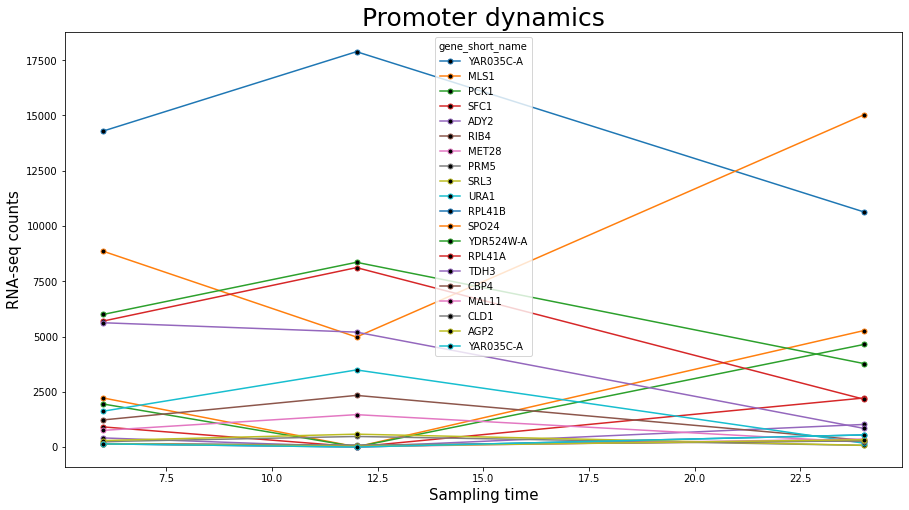

In [ ]:
transposed_plot1 = transposed_plot1.plot.line(linestyle='-', marker='o', markerfacecolor='black', legend = True, figsize=(15, 8),markersize=5)
transposed_plot1.set_title('Promoter dynamics', fontsize=25)
transposed_plot1.set_xlabel("Sampling time",fontsize=15)
transposed_plot1.set_ylabel("RNA-seq counts", fontsize=15)
#plt.savefig('../pictures/Promoter_dynamics.png', dpi = 120)

## 5. Selecting promoters:

At this point we can choose the promoters in 3 ways: 
1. Pick in a defined way from the lists (e.g. first and second element from the lists)
2. Randomly select promoters (with the built in random library) 
3. Arbitrarily choose promoter (from the dynamics above)

1st a way of choosing first and second element from the full list. 

In [ ]:
first_set_of_promoters = []
for i in range(0, len(all_promoter_names), 5):
    first_set_of_promoters.append(all_promoter_names[i])

second_set_of_promoters = []
for i in range(1, len(all_promoter_names), 5):
    second_set_of_promoters.append(all_promoter_names[i])
print(first_set_of_promoters)
print(second_set_of_promoters)

['YAR035C-A', 'RIB4', 'RPL41B', 'CBP4']
['MLS1', 'MET28', 'SPO24', 'MAL11']


Second way of choosing promoters - chosen at random

In [ ]:
## Using the random library to choose random promoters
import random

random.seed(1)

# First random set: 
set1 = [] 
set1.append(List_of_Top5_High_constitutive_promoters[int(len(List_of_Top5_High_constitutive_promoters)*random.random())])
set1.append(List_of_Top5_Low_constitutive_promoters[int(len(List_of_Top5_Low_constitutive_promoters)*random.random())])
set1.append(List_of_Top5_increasing_promoters[int(len(List_of_Top5_increasing_promoters)*random.random())])
set1.append(List_of_Top5_descreasing_promoters[int(len(List_of_Top5_descreasing_promoters)*random.random())])

# Can change the seed to get diffe
random.seed(3)

# Second random set: 
set2 = [] 
set2.append(List_of_Top5_High_constitutive_promoters[int(len(List_of_Top5_High_constitutive_promoters)*random.random())])
set2.append(List_of_Top5_Low_constitutive_promoters[int(len(List_of_Top5_Low_constitutive_promoters)*random.random())])
set2.append(List_of_Top5_increasing_promoters[int(len(List_of_Top5_increasing_promoters)*random.random())])
set2.append(List_of_Top5_descreasing_promoters[int(len(List_of_Top5_descreasing_promoters)*random.random())])

print(set1)
print(set2)

['RPL41B', 'YAR035C-A', 'SFC1', 'MET28']
['SPO24', 'CLD1', 'MLS1', 'SRL3']


#### Finally, we can choose arbitrarily from the dynamics that were plotted above. Here I think that the following promoters would be interesting to use for the genetic constructs because they show different characteristics: 
    
1. 'MLS1', 'URA1','YDR524W-A', 'FAA1'
2. 'PCK1','EXG1', 'RPL41A','LPD1'

Lets plot them: 
    

In [ ]:
df_with_prom1 = df_with_threshold.loc[['MLS1', 'URA1','YDR524W-A', 'FAA1']].transpose()
# Change the row indexes
df_with_prom1.index = [6, 12, 24]
df_with_prom1

gene_short_name,MLS1,URA1,YDR524W-A,FAA1
6,2222.16000,1618.990,5996.15,638.953
12,8.09464,3488.390,8357.58,829.516
24,5267.00000,175.513,3777.04,651.347


In [ ]:
df_with_prom2 = df_with_threshold.loc[['PCK1','EXG1', 'RPL41A','LPD1']].transpose()
df_with_prom2.index = [6, 12, 24]

df_with_prom2

gene_short_name,PCK1,EXG1,RPL41A,LPD1
6,1948.90000,932.374,5696.18,618.817
12,9.80902,1765.820,8116.95,470.309
24,4639.41000,176.603,2164.46,917.829


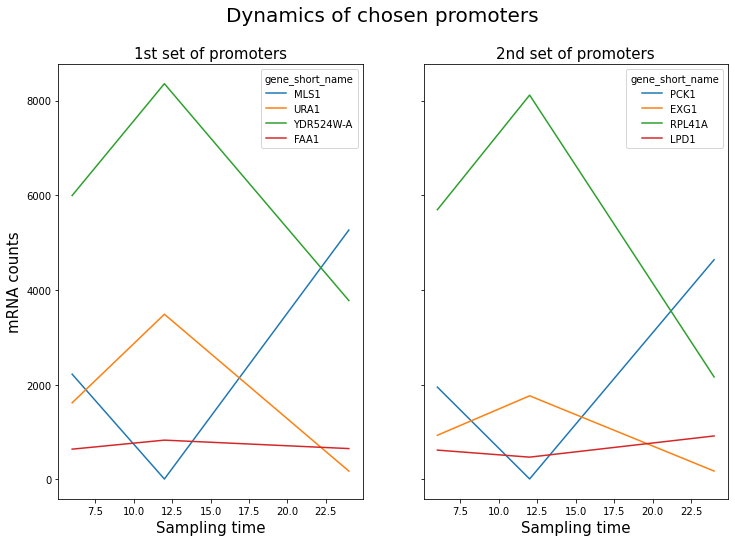

In [ ]:
# Plotting an empty subplot
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,8), sharey=True)  # 1 row, 2 columns 
# Adding the DFs
ax1 = df_with_prom1.plot( ax=ax1)
ax2 = df_with_prom2.plot( ax=ax2)

# Adding all the titles
ax1.set_title("1st set of promoters",  fontsize=15)
ax2.set_title("2nd set of promoters",  fontsize=15)
fig.suptitle("Dynamics of chosen promoters", fontsize=20)
ax1.set_ylabel("mRNA counts",  fontsize=15)
ax1.set_xlabel("Sampling time", fontsize=15)
ax2.set_ylabel("mRNA counts",  fontsize=15)
ax2.set_xlabel("Sampling time", fontsize=15)
ax1.get_shared_x_axes().join(ax1, ax2)
#plt.savefig('../pictures/Dynamics_of_chosen_promoters.png', dpi = 120)

If we want to choose completly arbitrarily from the whole dataset it is possible and this could be done as such: 

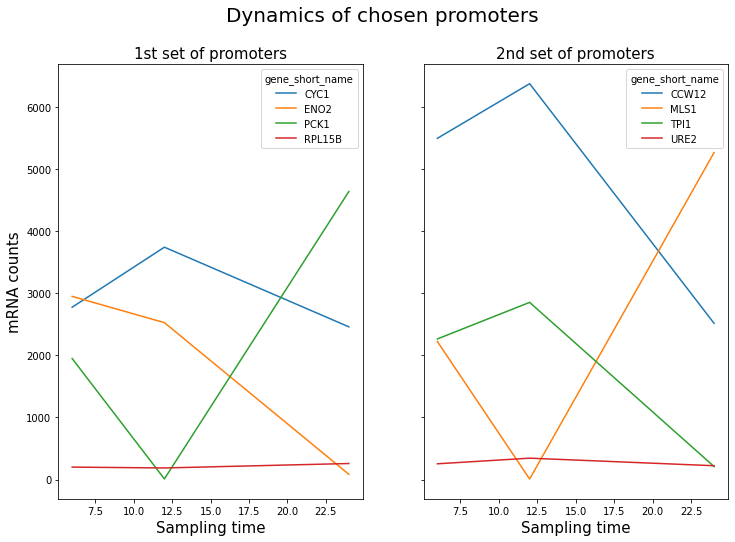

In [ ]:
df_with_prom1 = df_with_threshold.loc[['CYC1', 'ENO2', 'PCK1', 'RPL15B']].transpose()
df_with_prom1.index = [6, 12, 24]
df_with_prom2 = df_with_threshold.loc[['CCW12', 'MLS1', 'TPI1', 'URE2']].transpose()
df_with_prom2.index = [6, 12, 24]

# Plotting an empty subplot
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,8), sharey=True)  # 1 row, 2 columns 
# Adding the DFs
ax1 = df_with_prom1.plot( ax=ax1)
ax2 = df_with_prom2.plot( ax=ax2)

# Adding all the titles
ax1.set_title("1st set of promoters",  fontsize=15)
ax2.set_title("2nd set of promoters",  fontsize=15)
fig.suptitle("Dynamics of chosen promoters", fontsize=20)
ax1.set_ylabel("mRNA counts",  fontsize=15)
ax1.set_xlabel("Sampling time", fontsize=15)
ax2.set_ylabel("mRNA counts",  fontsize=15)
ax2.set_xlabel("Sampling time", fontsize=15)
ax1.get_shared_x_axes().join(ax1, ax2)
#plt.savefig('../pictures/Dynamics_of_chosen_promoters.png', dpi = 120)

In [ ]:
New_promoters = FetchMultiplePromoters(['CYC1', 'ENO2', 'PCK1', 'RPL15B','CCW12', 'MLS1', 'TPI1', 'URE2'] )
New_promoters

[SeqRecord(seq=Seq('GAGGCACCAGCGTCAGCATTTTCAAAGGTGTGTTCTTCGTCAGACATGTTTTAG...ATA'), id='CYC1', name='CYC1 Promoter', description='Defined as being 1kb upstream of the TSS and fetched from Intermines API', dbxrefs=[]),
 SeqRecord(seq=Seq('AATCCTACTCTTGCCGTTGCCATCCAAAATGAGCTAGAAGGTGGATTAACAAAT...ATA'), id='ENO2', name='ENO2 Promoter', description='Defined as being 1kb upstream of the TSS and fetched from Intermines API', dbxrefs=[]),
 SeqRecord(seq=Seq('ACATGTCGACGAGTTTGTCATCGAATCCGTAATGAAGGCGCAAGAAAAACTAGA...AAC'), id='PCK1', name='PCK1 Promoter', description='Defined as being 1kb upstream of the TSS and fetched from Intermines API', dbxrefs=[]),
 SeqRecord(seq=Seq('AAGCGGAAGCGGAAGTGGAAGTACTGCTGGCCATTTTTATTCAGGTTATTTGCG...GCA'), id='RPL15B', name='RPL15B Promoter', description='Defined as being 1kb upstream of the TSS and fetched from Intermines API', dbxrefs=[]),
 SeqRecord(seq=Seq('AACCAGGGCAAAGCAAAATAAAAGAAACTTAATACGTTATGCCGTAATGAAGGG...ATA'), id='CCW12', name='CCW12 Promoter', descr

## Retrieving first set of promoters from all of the promoters

In [ ]:
Promoters_we_want_to_bounce = ['CYC1', 'ENO2', 'PCK1', 'RPL15B']
Promoters_for_fasta = []

for i in range(0, len(New_promoters)): 
    for j in range(0, len(Promoters_we_want_to_bounce)): 
        if New_promoters[i].id == Promoters_we_want_to_bounce[j]: 
            Promoters_for_fasta.append(New_promoters[i])
        
Promoters_for_fasta

[SeqRecord(seq=Seq('GAGGCACCAGCGTCAGCATTTTCAAAGGTGTGTTCTTCGTCAGACATGTTTTAG...ATA'), id='CYC1', name='CYC1 Promoter', description='Defined as being 1kb upstream of the TSS and fetched from Intermines API', dbxrefs=[]),
 SeqRecord(seq=Seq('AATCCTACTCTTGCCGTTGCCATCCAAAATGAGCTAGAAGGTGGATTAACAAAT...ATA'), id='ENO2', name='ENO2 Promoter', description='Defined as being 1kb upstream of the TSS and fetched from Intermines API', dbxrefs=[]),
 SeqRecord(seq=Seq('ACATGTCGACGAGTTTGTCATCGAATCCGTAATGAAGGCGCAAGAAAAACTAGA...AAC'), id='PCK1', name='PCK1 Promoter', description='Defined as being 1kb upstream of the TSS and fetched from Intermines API', dbxrefs=[]),
 SeqRecord(seq=Seq('AAGCGGAAGCGGAAGTGGAAGTACTGCTGGCCATTTTTATTCAGGTTATTTGCG...GCA'), id='RPL15B', name='RPL15B Promoter', description='Defined as being 1kb upstream of the TSS and fetched from Intermines API', dbxrefs=[])]

## Retrieving second set of promoters from all of the promoters

In [ ]:
Promoters_we_want_to_bounce1 = ['CCW12', 'MLS1', 'TPI1', 'URE2']

Promoters_for_fasta1 = []

for i in range(0, len(New_promoters)): 
    for j in range(0, len(Promoters_we_want_to_bounce1)): 
        if New_promoters[i].id == Promoters_we_want_to_bounce1[j]: 
            Promoters_for_fasta1.append(New_promoters[i])

Promoters_for_fasta1

[SeqRecord(seq=Seq('AACCAGGGCAAAGCAAAATAAAAGAAACTTAATACGTTATGCCGTAATGAAGGG...ATA'), id='CCW12', name='CCW12 Promoter', description='Defined as being 1kb upstream of the TSS and fetched from Intermines API', dbxrefs=[]),
 SeqRecord(seq=Seq('TTTAATCTTTAGGGAGGGTAAAGTTGGATTCATCAATTTGATGAAATCCGTGTA...AAA'), id='MLS1', name='MLS1 Promoter', description='Defined as being 1kb upstream of the TSS and fetched from Intermines API', dbxrefs=[]),
 SeqRecord(seq=Seq('AAGGATGAGCCAAGAATAAGGGAACAAGATTTTGGTAATTTCCAAAAAATCAAT...AAA'), id='TPI1', name='TPI1 Promoter', description='Defined as being 1kb upstream of the TSS and fetched from Intermines API', dbxrefs=[]),
 SeqRecord(seq=Seq('GCTGAACTCGCTGAAATTGAAAGAAAACTGGCAGAATCGTCTTCTGAAGACGAA...CAA'), id='URE2', name='URE2 Promoter', description='Defined as being 1kb upstream of the TSS and fetched from Intermines API', dbxrefs=[])]

## 6. Exporting the sequemces as FASTA file 

In [ ]:
with open('/content/ConStrain_on_google_colab/Data/G8H_CYP_CPR_PARTS/Promoter_sequences_1.fasta', 'w') as outfile:
    for i in range(0, len(Promoters_for_fasta)):
        print(Promoters_for_fasta[i].format("fasta"), file = outfile)

In [ ]:
with open('/content/ConStrain_on_google_colab/Data/G8H_CYP_CPR_PARTS/Promoter_sequences_2.fasta', 'w') as outfile:
    for i in range(0, len(Promoters_for_fasta1)):
        print(Promoters_for_fasta1[i].format("fasta"), file = outfile)

We can asses homology with different tools and one of them is  https://www.ebi.ac.uk/Tools/msa/clustalo/


After running an sequence alignment the following result was obtained: 



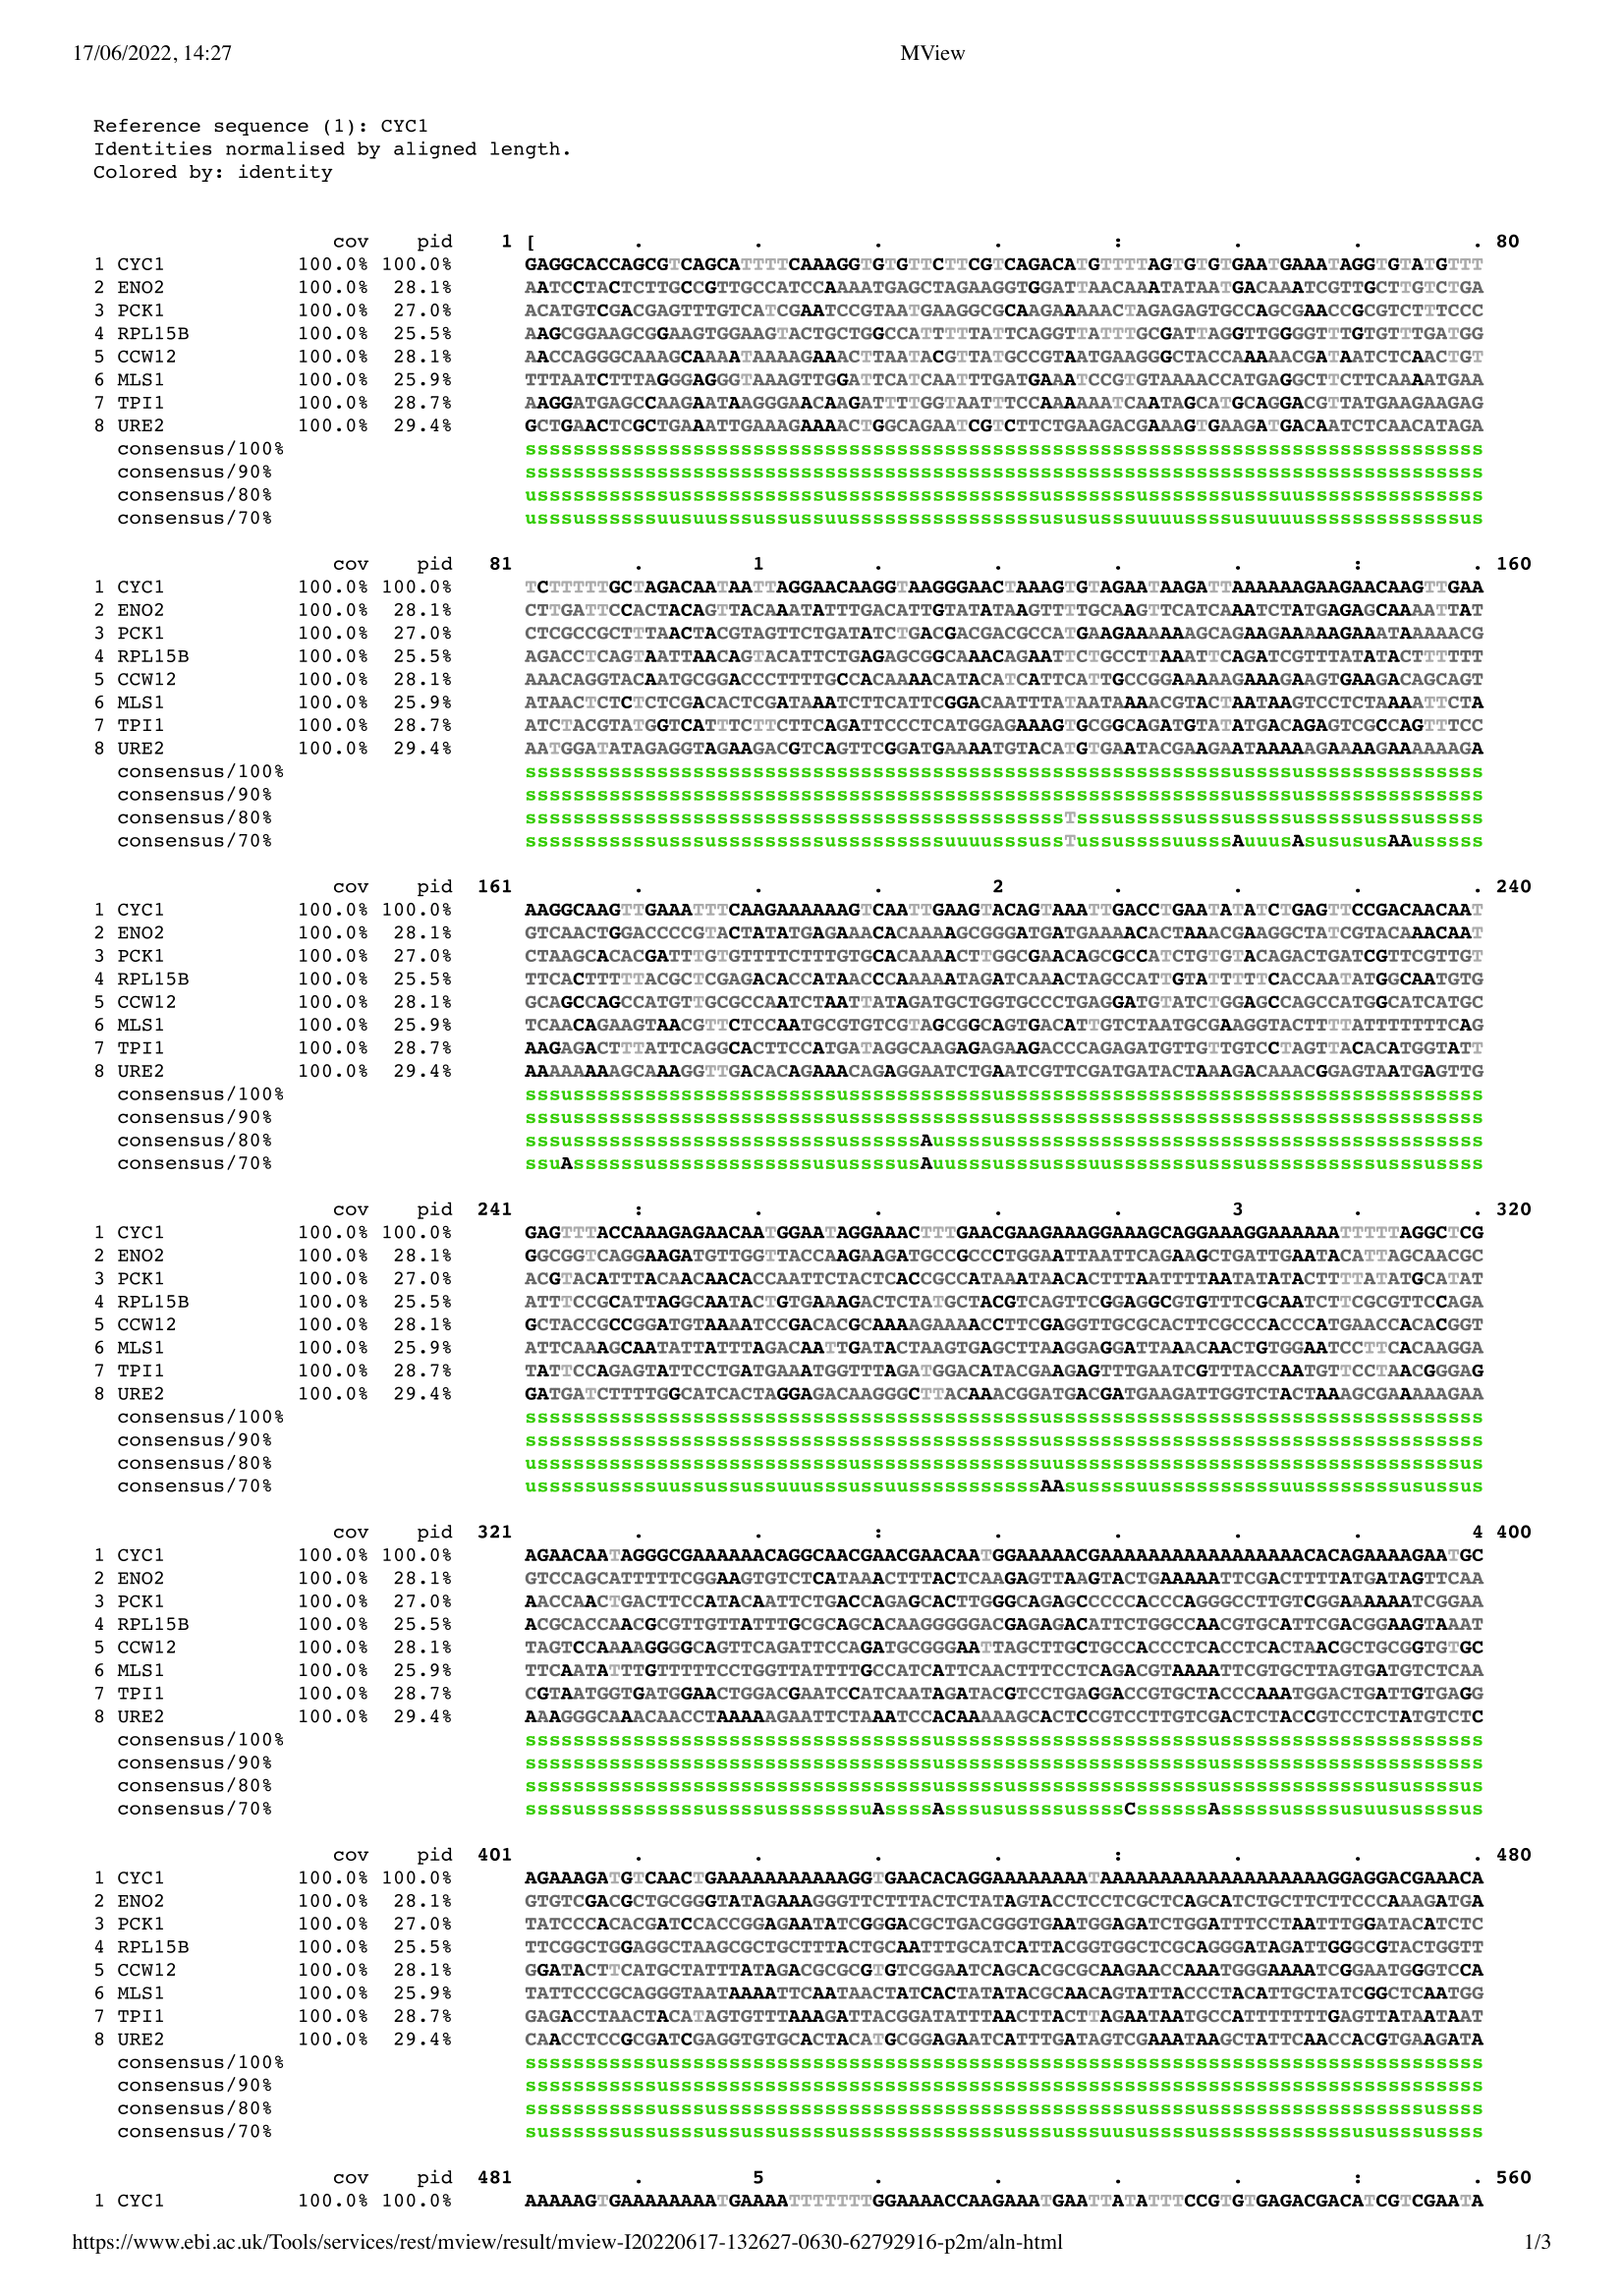

In [ ]:
import IPython
IPython.core.display.Image('/content/ConStrain_on_google_colab/pictures/Promoters_homology-1.png', width=800)

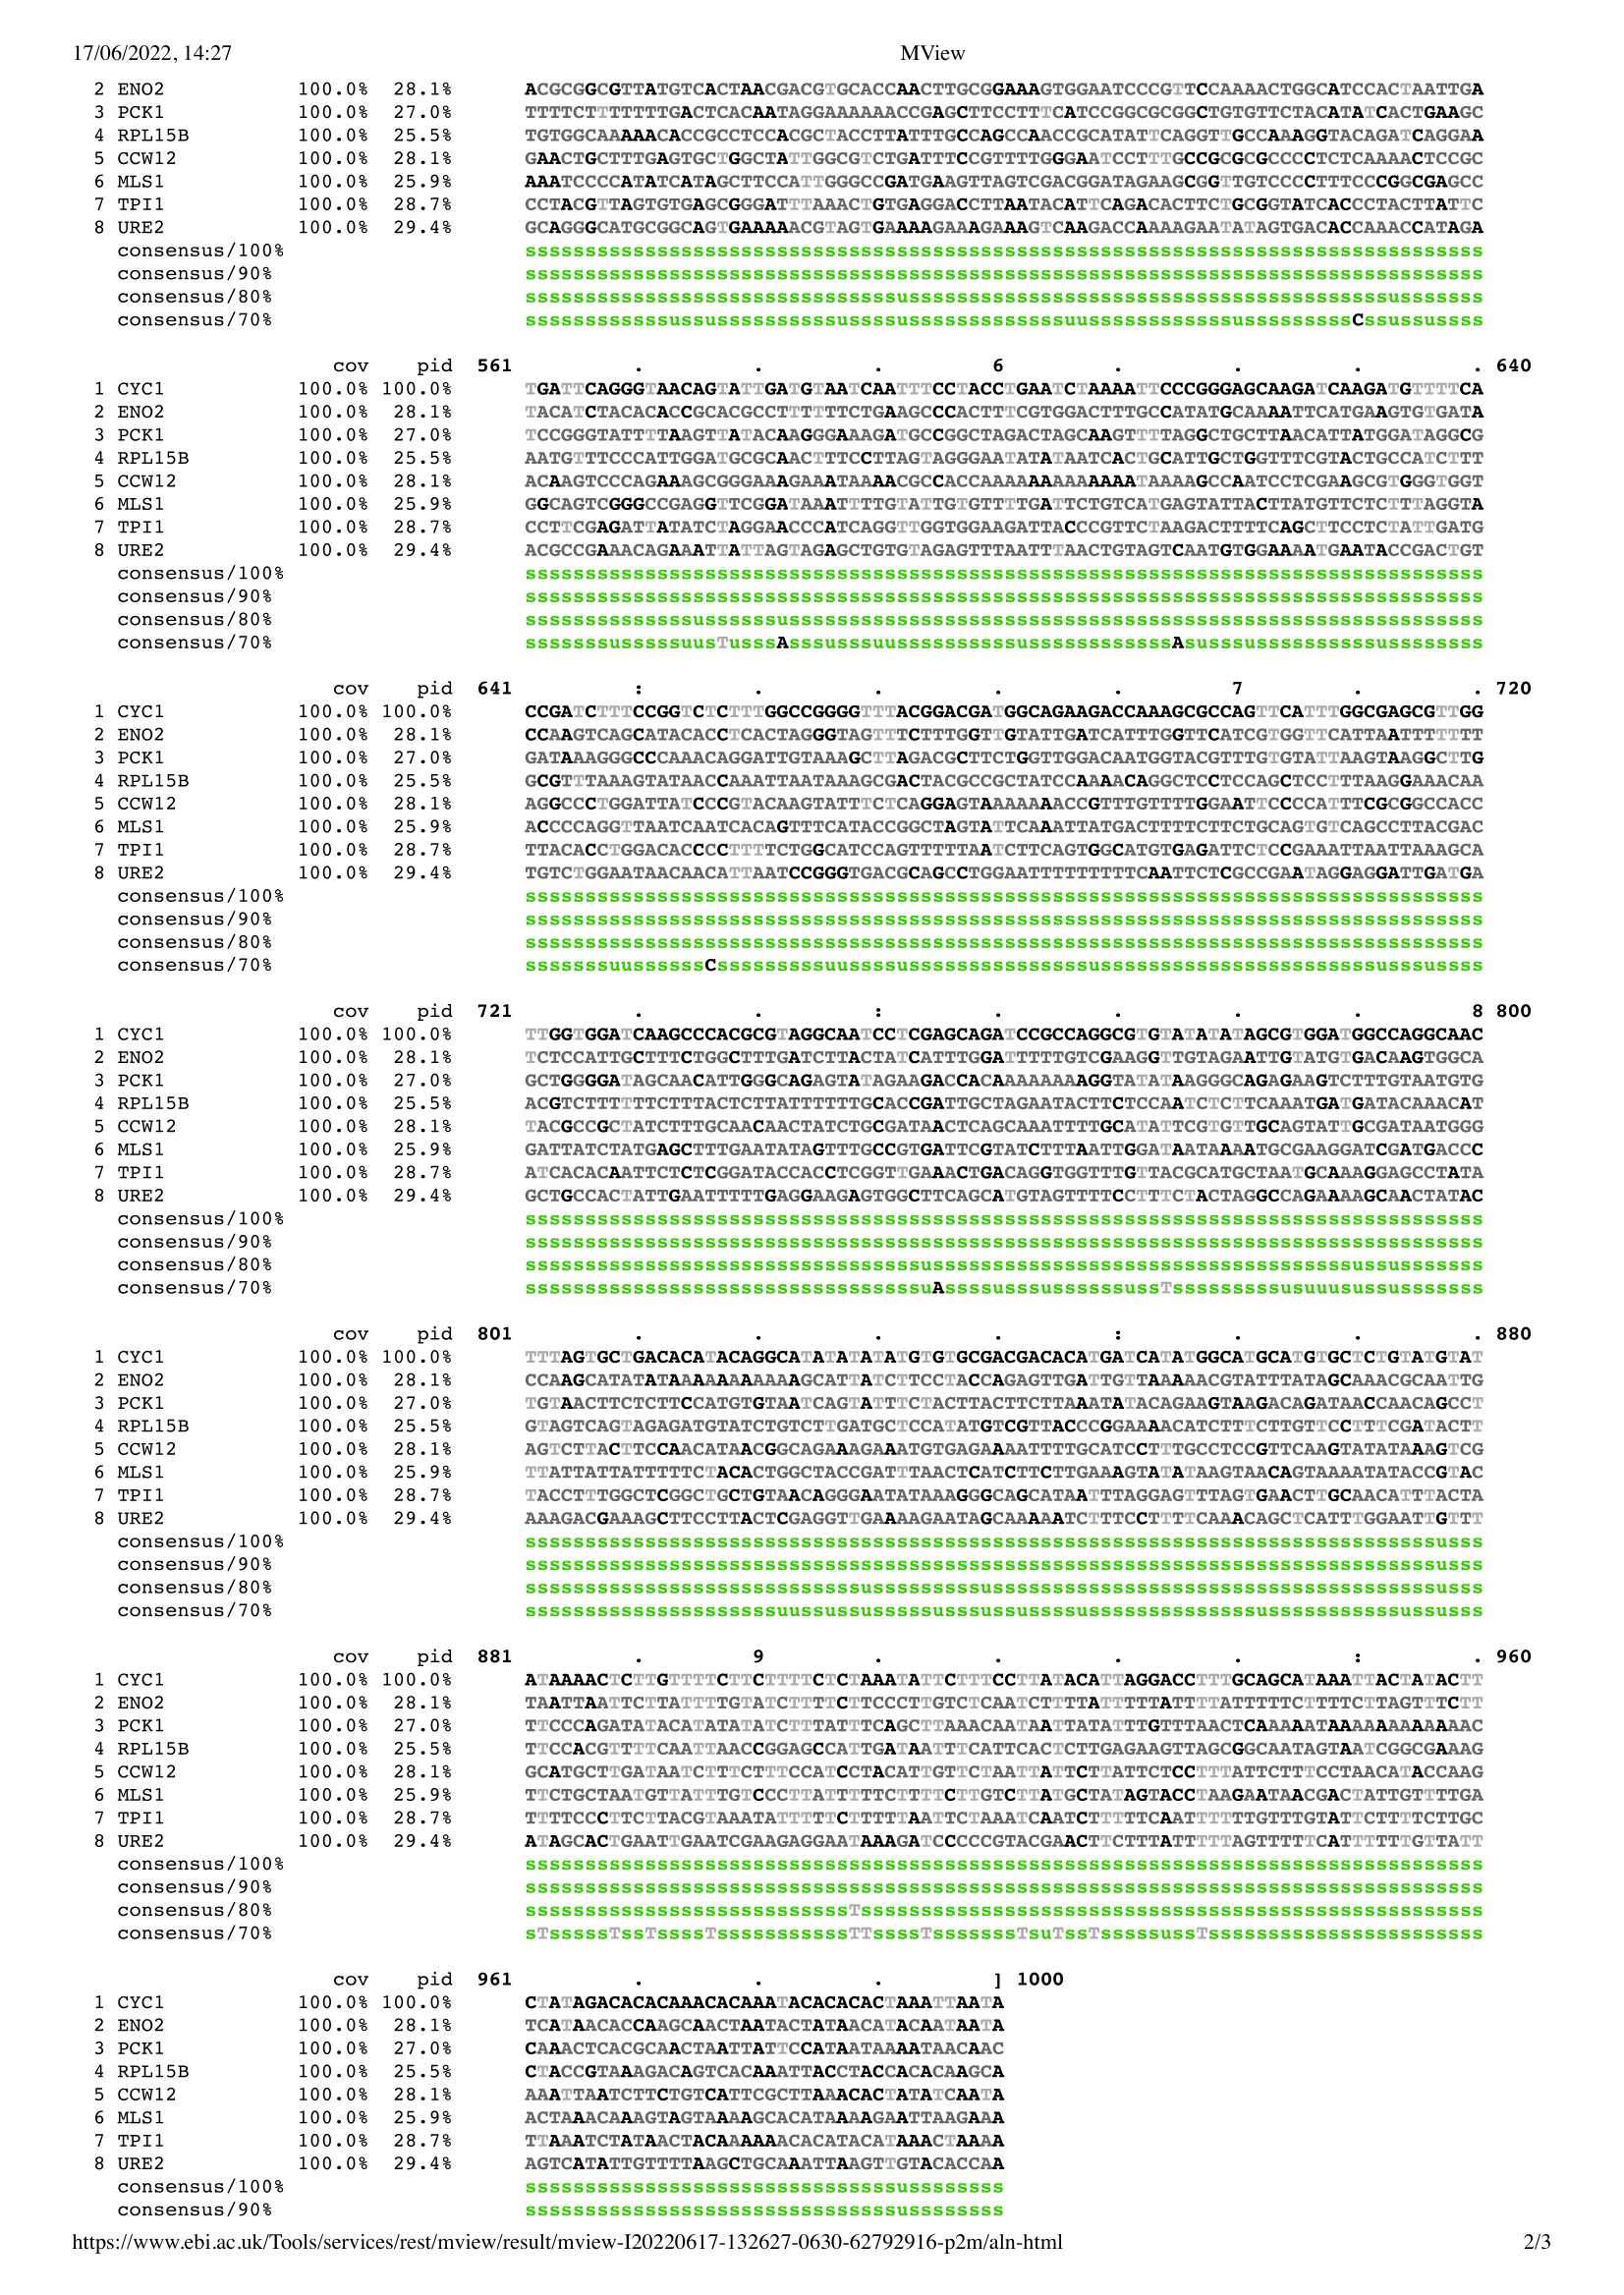

In [ ]:
IPython.core.display.Image('/content/ConStrain_on_google_colab/pictures/Promoters_homology-2.png', width=800)

# Refences 

Kotopka, B. and Smolke, C., 2020. Model-driven generation of artificial yeast promoters. Nature Communications, 11(1).

Rajkumar, A., Özdemir, E., Lis, A., Schneider, K., Qin, J., Jensen, M. and Keasling, J., 2019. Engineered Reversal of Function in Glycolytic Yeast Promoters. ACS Synthetic Biology, 8(6), pp.1462-1468.